In this project, we will use the Resnet that we trained to annotate images.

This project is more or less a failure in the allotted time. More consideration is needed since the training certainly did not work as intended. I will explain the thought process throughout and remark about what could have been made better!

The image annotations consist of bounding boxes which envelope a single object and labels for each object in the bounding box. Our training set is given by COCO 2014.

Our first task is to modify the the neural network that we trained in file 1 to be adapted for the much smaller list of classes in COCO. COCO consists of 80 categories:

person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic_light, fire_hydrant, stop_sign, parking_meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports_ball, kite, baseball_bat, baseball_glove, skateboard, surfboard, tennis_racket, bottle, wine_glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot_dog, pizza, donut, cake, chair, couch, potted_plant, bed, dining_table, toilet, tv, laptop, mouse, remote, keyboard, cell_phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy_bear, hair_drier, toothbrush

In order to facilitate the smaller class, set we we freeze the hidden layers of the network and learn the fully connected output layer.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
    

Here we have code to load in the weights from the Resnet created from file 1. Unfortunately, there were many unresolved issues with this step since I wanted to run the training with cuda, but there seems to be some fundamental incompatibility stemming from the fact that the original weights were trained using mps. This is something I will need to look into more. In any case, what makes this code interesting is that I freeze the weights of most of the network, but keep the last basic block and fully connected layer trainable. This makes sense since I'd like to specialize the data to the coco dataset.

In [4]:
import subprocess
from pathlib import Path
import torch
import os



# Get Git repository root dynamically
repo_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip()

# Define path relative to Git repo root
weights_path = Path(repo_root) / "resnet18_weights.pth"

#weights_path = '/home/ryan/Deep_Learning/resnet18_weights.pth'
print(f"Loading weights from: {weights_path}")

num_coco_classes = 80  # Adjust for your dataset
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_coco_classes)

# Load the checkpoint, but ignore incompatible layers
checkpoint = torch.load(weights_path, map_location='cpu')

# Remove the fc layer weights from the loaded checkpoint
del checkpoint['fc.weight']
del checkpoint['fc.bias']

# Load the model ignoring the fc layer
model.load_state_dict(checkpoint, strict=False)


# Define new fully connected layer with correct number of classes
model.fc = nn.Linear(model.fc.in_features, num_coco_classes)




# Move model to the appropriate device (GPU if available)
hardware = "cpu"
if torch.mps.is_available():
    hardware = "mps"

device = torch.device(hardware)

model = model.to(device)

print("Model loaded and transferred to:", device)


# Freeze all layers except the last block and fc
for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Training: {name}")
    else:
        print(f"Frozen: {name}")

Loading weights from: /home/ryan/Deep_Learning/resnet18_weights.pth
Model loaded and transferred to: cpu
Frozen: conv1.weight
Frozen: bn1.weight
Frozen: bn1.bias
Frozen: layer1.0.conv1.weight
Frozen: layer1.0.bn1.weight
Frozen: layer1.0.bn1.bias
Frozen: layer1.0.conv2.weight
Frozen: layer1.0.bn2.weight
Frozen: layer1.0.bn2.bias
Frozen: layer1.1.conv1.weight
Frozen: layer1.1.bn1.weight
Frozen: layer1.1.bn1.bias
Frozen: layer1.1.conv2.weight
Frozen: layer1.1.bn2.weight
Frozen: layer1.1.bn2.bias
Frozen: layer2.0.conv1.weight
Frozen: layer2.0.bn1.weight
Frozen: layer2.0.bn1.bias
Frozen: layer2.0.conv2.weight
Frozen: layer2.0.bn2.weight
Frozen: layer2.0.bn2.bias
Frozen: layer2.0.downsample.0.weight
Frozen: layer2.0.downsample.1.weight
Frozen: layer2.0.downsample.1.bias
Frozen: layer2.1.conv1.weight
Frozen: layer2.1.bn1.weight
Frozen: layer2.1.bn1.bias
Frozen: layer2.1.conv2.weight
Frozen: layer2.1.bn2.weight
Frozen: layer2.1.bn2.bias
Frozen: layer3.0.conv1.weight
Frozen: layer3.0.bn1.weight

/tmp/ipykernel_14940/683910650.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location='cpu')


To test that this has work, we run a forward pass.

In [3]:
# Generate a random tensor of the correct input size (batch_size, channels, height, width)
batch_size = 8  # Example batch size
input_tensor = torch.randn(batch_size, 3, 224, 224).to(device)

# Perform a forward pass
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    output = model(input_tensor)

# Print the output shape
print(f"Output shape: {output.shape}") 

Output shape: torch.Size([8, 80])


Now we load in the data. This was itself very difficult since unlike imagenet data, there is no uniform size to this data. What I do here is a extract the subimages coming from the training annotations of the COCO dataset and I create a custom data_loader which transform the images as expected.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CocoDetection
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision.ops import box_iou
import os



if hardware == 'cpu':
    coco_root = "/home/ryan/Documents/COCO/train2014"  # Update with your dataset path
    coco_ann = "/home/ryan/Documents/COCO/annotations/instances_train2014.json"  # Update annotation path

else:
    coco_root = "/Users/ryanaschoff/Documents/COCO/train2014"  # Update with your dataset path
    coco_ann = "/Users/ryanaschoff/Documents/COCO/annotations/instances_train2014.json"  # Update annotation path



# Define transformations for subimages
subimage_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load COCO annotation file to get category mappings
coco = COCO(coco_ann)
coco_cat_ids = sorted(coco.getCatIds())  # Get all COCO category IDs
coco_id_to_label = {cat_id: idx for idx, cat_id in enumerate(coco_cat_ids)}

class CustomCocoDataset(CocoDetection):
    def __getitem__(self, index):
        # Get image and target annotations using the base class
        image, target = super().__getitem__(index)

        subimages = []
        labels = []
        
        for ann in target:
            bbox = ann['bbox']  # COCO format: [x, y, width, height]
            category_id = ann['category_id']

            # Check if the category_id exists in our mapping
            if category_id not in coco_id_to_label:
                continue  # Ignore categories not in our mapping

            label = coco_id_to_label[category_id]  # Map category_id to 0-based index
            x, y, w, h = map(int, bbox)

            # Ensure bbox coordinates are within image bounds
            if x < 0 or y < 0 or w <= 0 or h <= 0 or (x + w) > image.width or (y + h) > image.height:
                continue

            # Crop the subimage based on the bounding box
            subimage = image.crop((x, y, x + w, y + h))

            # Apply transformation to the cropped subimage
            subimage = subimage_transform(subimage)

            subimages.append(subimage)
            labels.append(label)

        if subimages:
            subimages = torch.stack(subimages)  # Shape: [num_objects, 3, 224, 224]
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            subimages = torch.empty(0, 3, 224, 224)
            labels = torch.empty(0, dtype=torch.long)

        return subimages, labels


def flatten_collate_fn(batch):
    all_subimages = []
    all_labels = []

    for subimages, labels in batch:
        all_subimages.append(subimages)  # Add subimages directly
        all_labels.append(labels)  # Add corresponding labels

    # Flatten the list of subimages and labels
    all_subimages = torch.cat(all_subimages, dim=0)  # Combine subimages across all samples
    all_labels = torch.cat(all_labels, dim=0)  # Combine labels across all samples

    return all_subimages, all_labels

full_dataset = CustomCocoDataset(root=coco_root, annFile=coco_ann)

# Split dataset into training and validation sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders with the custom collate function
train_loader = DataLoader(
    train_dataset, 
    batch_size=8,  
    shuffle=True, 
    num_workers=6, 
    pin_memory=True, 
    collate_fn=flatten_collate_fn  # Ensure consistent handling across datasets
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=8,  
    shuffle=False, 
    num_workers=4, 
    pin_memory=True, 
    collate_fn=flatten_collate_fn
)


loading annotations into memory...
Done (t=7.44s)
creating index...
index created!
loading annotations into memory...
Done (t=7.37s)
creating index...
index created!


I want to see that the batch size is correc and the labels are appropriate. I check this due to some previous issues that have since been resolved.

In [5]:
for subimages, labels in train_loader:
    print(f"Subimage batch shape: {subimages.shape}")  # Expected shape: [total_subimages, 3, 224, 224]
    print(f"Labels shape: {labels.shape}")  # Expected shape: [total_subimages]
    print(f"Sample labels (remapped): {labels.tolist()}")
    assert labels.max() < num_coco_classes, "Found label index exceeding expected range!"
    break

import os


Subimage batch shape: torch.Size([46, 3, 224, 224])
Labels shape: torch.Size([46])
Sample labels (remapped): [16, 15, 57, 48, 0, 52, 52, 60, 60, 0, 0, 36, 41, 0, 34, 35, 14, 14, 14, 63, 16, 0, 57, 0, 0, 0, 34, 35, 0, 2, 2, 2, 2, 2, 2, 7, 35, 0, 2, 2, 2, 2, 2, 2, 2, 2]


Now its time to train on the data. For the training, I have learned that I need to do file saves every 10 minutes and incorporate the validation data to check that the training is sufficient and that no overfitting is occuring.

In [6]:

import time

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def validate_model():
    model.eval()
    val_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for subimages, labels in val_loader:
            i+=1
            subimages, labels = subimages.to(device), labels.to(device)

            # Ensure labels are within the correct range
            if torch.max(labels) >= num_coco_classes or torch.min(labels) < 0:
                print(f"Warning: Found out-of-range labels {labels.tolist()}")
                continue

            # Forward pass through the model
            outputs = model(subimages)
            probs = torch.softmax(outputs, dim=1)
            confidence, pred_labels = torch.max(probs, 1)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate loss across the batch
            val_loss += loss.item() * subimages.size(0)
            total_samples += subimages.size(0)
    # Return average validation loss
    return val_loss / total_samples if total_samples > 0 else float('inf')



def train_model(num_epochs=10, confidence_threshold=0.0, save_dir="/home/ryan/Documents/COCO"):
    best_val_loss = float('inf')
    save_interval = 600  # 10 minutes in seconds
    last_save_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for subimages, labels in train_loader:  # Process subimages directly
            subimages, labels = subimages.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero gradients before processing the batch

            # Forward pass through the model
            outputs = model(subimages)
            probs = torch.softmax(outputs, dim=1)
            confidence, pred_labels = torch.max(probs, 1)

            # Filter out low-confidence predictions
            valid_indices = confidence >= confidence_threshold

            if valid_indices.sum() == 0:
                continue  # Skip batch if no predictions exceed confidence threshold

            valid_subimages = subimages[valid_indices]
            valid_labels = labels[valid_indices]

            # Compute loss only on high-confidence samples
            loss = criterion(outputs[valid_indices], valid_labels)

            loss.backward()  # Backpropagate accumulated loss
            optimizer.step()  # Update model after processing the batch

            running_loss += loss.item()

            # Save checkpoint every 10 minutes without interrupting training
            current_time = time.time()
            if current_time - last_save_time >= save_interval:
                save_path = os.path.join(save_dir, f'model_checkpoint_epoch_{epoch}_time_{current_time}.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, save_path)
                print(f"Checkpoint saved at {save_path}")
                last_save_time = current_time  # Reset the timer            
        # Perform validation after each epoch
        val_loss = validate_model()
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(save_dir, f'resnet50_best.pth')
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved to {save_path}")
        else:
            print("Early stopping, validation loss did not improve.")
            break

    print("Training complete.")
# Train the model
train_model()




Checkpoint saved at /home/ryan/Documents/COCO/model_checkpoint_epoch_0_time_1737742830.3178973.pth
Checkpoint saved at /home/ryan/Documents/COCO/model_checkpoint_epoch_0_time_1737743430.5824175.pth
Checkpoint saved at /home/ryan/Documents/COCO/model_checkpoint_epoch_0_time_1737744031.6938806.pth
Checkpoint saved at /home/ryan/Documents/COCO/model_checkpoint_epoch_0_time_1737744632.9559476.pth
Checkpoint saved at /home/ryan/Documents/COCO/model_checkpoint_epoch_0_time_1737745233.0284684.pth
Checkpoint saved at /home/ryan/Documents/COCO/model_checkpoint_epoch_0_time_1737745833.1986566.pth
Checkpoint saved at /home/ryan/Documents/COCO/model_checkpoint_epoch_0_time_1737746435.0427158.pth


KeyboardInterrupt: 

unfortunately, with the time that I had, I needed to stop the model early. I ran the model a few days prior for about 1.5 days, however because there was a serious issue with the code, the model didn't end up learning anything useful! 

In [ ]:
save_path = os.path.join('/Users/ryanaschoff/Documents/COCO/', f'model_checkpoint_epoch_0_time_1737746435.0427158.pth')
torch.save(model.state_dict(), save_path)

Now we want to check that our model and algorithm actually work. We create a new dataset where we have the raw images from COCO. We also reload the model from a save file since the ipython kernel failed at one point. There is some additional code making using of OpenCVs selective segmentation which is the method we use to generate bounding boxes.

In [ ]:

# Get Git repository root dynamically
repo_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip()

# Define path relative to Git repo root
weights_path = Path(repo_root) / "model_checkpoint_epoch_0_time_1737746435.0427158.pth"

model.load_state_dict(torch.load(weights_path, map_location='cpu')["model_state_dict"])



In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CocoDetection
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision.ops import box_iou
import subprocess
from pathlib import Path
import os
import gc

gc.collect()


# Get Git repository root dynamically
repo_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip()

# Define path relative to Git repo root
weights_path = Path(repo_root) / "model_checkpoint_epoch_0_time_1737746435.0427158.pth"



model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_coco_classes)
model.load_state_dict(torch.load(weights_path, map_location='cpu')["model_state_dict"])

if hardware == 'cpu':
    coco_root = "/home/ryan/Documents/COCO/train2014"  # Update with your dataset path
    coco_ann = "/home/ryan/Documents/COCO/annotations/instances_train2014.json"  # Update annotation path

else:
    coco_root = "/Users/ryanaschoff/Documents/COCO/train2014"  # Update with your dataset path
    coco_ann = "/Users/ryanaschoff/Documents/COCO/annotations/instances_train2014.json"  # Update annotation path



# Define transformations for subimages
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load COCO annotation file to get category mappings
coco = COCO(coco_ann)
coco_cat_ids = sorted(coco.getCatIds())  # Get all COCO category IDs
coco_id_to_label = {cat_id: idx for idx, cat_id in enumerate(coco_cat_ids)}

# Custom dataset class to return raw images without transformations
class RawCocoDataset(CocoDetection):
    def __getitem__(self, index):
        # Get image and target annotations using the base class
        image, target = super().__getitem__(index)

        # Extract bounding boxes and category IDs
        bboxes = [ann['bbox'] for ann in target]  # COCO bbox format: [x, y, width, height]
        labels = [ann['category_id'] for ann in target]

        return image, {'bboxes': bboxes, 'labels': labels}

# Load the COCO dataset without transformations
raw_dataset = RawCocoDataset(root=coco_root, annFile=coco_ann, transform =transform)

# Split the dataset into training and validation sets
total_size = len(raw_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(raw_dataset, [train_size, val_size])

# Create DataLoaders
train_loader_raw = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
val_loader_raw = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")


# Convert COCO bbox format [x, y, w, h] -> [x_min, y_min, x_max, y_max]
def coco_to_xyxy(box):
    x_min, y_min, width, height = box
    x_max = x_min + width
    y_max = y_min + height
    return [x_min, y_min, x_max, y_max]


# Function to generate proposals using Selective Search
def get_selective_search_proposals(image_path):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    image = cv2.imread(image_path)
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchQuality()  # Higher quality proposals
    rects = ss.process()
    return rects[:200]  # Limit number of proposals

# Function to compute IoU
def compute_iou(true_boxes, pred_boxes):
    true_boxes = torch.tensor(true_boxes, dtype=torch.float32)
    pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
    return box_iou(true_boxes, pred_boxes)


/tmp/ipykernel_14940/3825545255.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location='cpu')["model_state_dict"])


loading annotations into memory...
Done (t=6.40s)
creating index...
index created!
loading annotations into memory...
Done (t=7.80s)
creating index...
index created!
Loaded 66226 training images and 16557 validation images.


In this code, we use the selective segmentation function to generate 200 regions of interest which we will resize and run the classifier on. If there are any regions of high confidence we accepts those regions for the image annotation. Lastly, we exclude any regions from the annotations which have significant overlap with smaller bounding boxes and the same classification. 

(0, 360, 17, 28)
(565, 540, 61, 21)
(170, 20, 20, 14)
(261, 231, 15, 17)
(359, 467, 113, 96)
(484, 185, 30, 25)
(299, 9, 58, 27)
(392, 457, 43, 8)
(365, 183, 22, 40)
(188, 604, 18, 26)
(143, 230, 16, 14)
(448, 418, 40, 19)
(486, 371, 54, 51)
(470, 0, 27, 27)
(126, 540, 43, 13)
(5, 46, 23, 31)
(169, 400, 69, 51)
(532, 87, 16, 20)
(309, 52, 35, 36)
(72, 620, 31, 20)
(551, 269, 17, 24)
(445, 253, 16, 14)
(341, 549, 99, 30)
(0, 75, 46, 59)
(179, 487, 21, 36)
(289, 326, 15, 26)
(344, 0, 46, 23)
(508, 321, 16, 16)
(555, 449, 11, 24)
(443, 39, 25, 23)
(358, 108, 30, 43)
(497, 202, 41, 81)
(591, 211, 49, 64)
(24, 101, 38, 16)
(51, 0, 26, 53)
(276, 0, 77, 25)
(544, 442, 47, 63)
(59, 165, 10, 33)
Found: tensor([0])
(221, 434, 39, 32)
(217, 0, 45, 29)
(27, 472, 16, 28)
(479, 519, 29, 17)
(567, 420, 73, 120)
(632, 511, 8, 16)
Found: tensor([0])
(478, 45, 69, 26)
(75, 376, 15, 35)
(217, 0, 31, 29)
(427, 0, 134, 88)
(544, 510, 64, 53)
(430, 206, 24, 14)
(381, 448, 43, 17)
(336, 613, 27, 27)
(593, 11

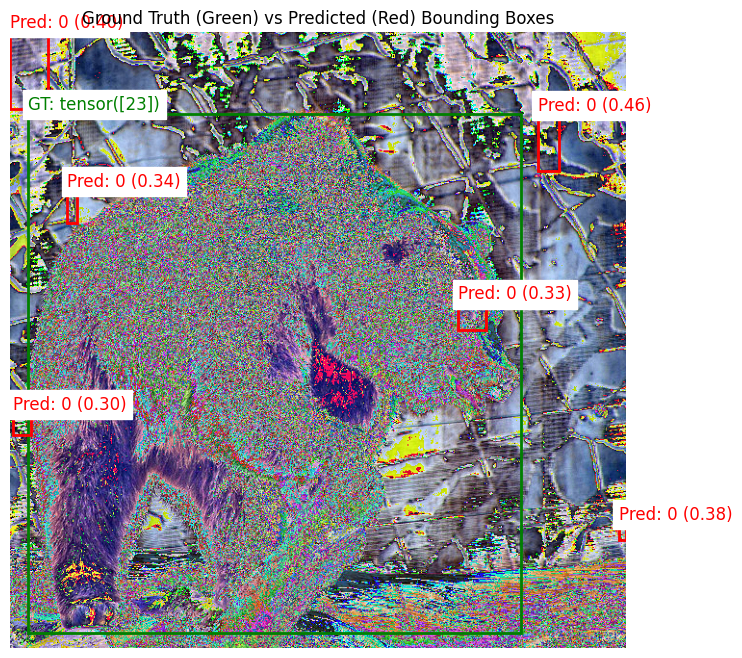

(177, 72, 29, 21)
(0, 304, 136, 260)
Found: tensor([0])
(0, 73, 455, 453)
(125, 301, 78, 228)
(421, 126, 34, 21)
(198, 316, 13, 35)
Found: tensor([0])
(454, 292, 26, 19)
(36, 322, 31, 38)
(383, 507, 31, 18)
(427, 481, 24, 13)
(434, 290, 16, 11)
(163, 253, 13, 24)
(0, 24, 40, 40)
(79, 330, 23, 34)
(165, 170, 23, 40)
(15, 602, 41, 38)
(12, 0, 20, 10)
(229, 381, 17, 18)
(132, 262, 39, 50)
Found: tensor([0])
(26, 136, 46, 21)
(221, 275, 19, 15)
Found: tensor([0])
(117, 297, 17, 16)
(98, 327, 30, 67)
(198, 311, 16, 38)
Found: tensor([0])
(269, 512, 56, 24)
(409, 493, 30, 21)
(79, 403, 48, 97)
Found: tensor([0])
(144, 330, 142, 188)
(135, 394, 108, 128)
(406, 322, 29, 15)
(201, 327, 28, 20)
(212, 295, 59, 29)
(207, 255, 11, 21)
(0, 550, 74, 41)
(349, 261, 32, 30)
(108, 448, 20, 22)
Found: tensor([0])
(287, 538, 37, 18)
(0, 78, 52, 21)
(298, 181, 17, 23)
(407, 285, 23, 14)
(152, 220, 32, 38)
(422, 563, 58, 18)
(0, 80, 25, 17)
(206, 500, 44, 17)
(445, 430, 20, 11)
(30, 328, 18, 14)
(0, 251, 48

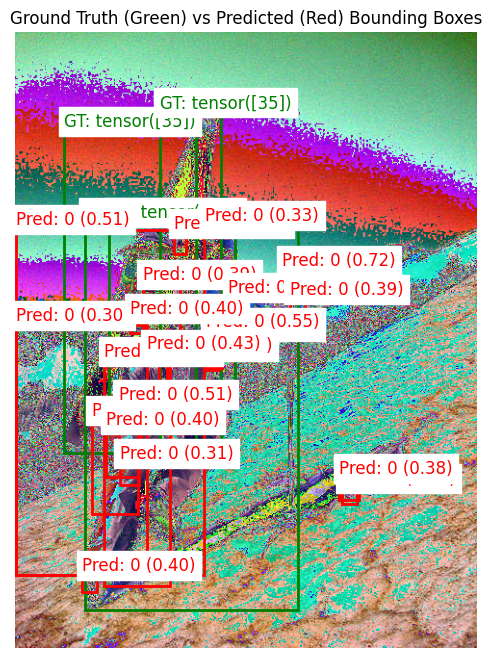

(302, 168, 24, 44)
(106, 87, 31, 18)
(212, 174, 185, 180)
(238, 91, 38, 19)
(300, 114, 36, 35)
(256, 150, 14, 29)
(204, 74, 33, 35)
(142, 164, 40, 36)
(245, 40, 35, 13)
(0, 240, 460, 135)
(260, 33, 31, 12)
(305, 293, 15, 21)
(0, 157, 55, 79)
(239, 90, 37, 20)
(206, 316, 54, 18)
(326, 211, 25, 19)
(41, 268, 44, 29)
(15, 164, 91, 62)
(199, 0, 21, 10)
(232, 4, 47, 18)
(302, 172, 18, 38)
(105, 170, 45, 31)
(0, 259, 164, 101)
(47, 228, 15, 20)
(345, 160, 15, 27)
(124, 182, 15, 38)
(437, 236, 63, 38)
(403, 239, 11, 22)
(182, 136, 71, 44)
(9, 0, 52, 61)
(289, 201, 28, 20)
(380, 42, 40, 90)
(140, 0, 271, 212)
(339, 146, 18, 21)
(153, 53, 34, 43)
(325, 0, 56, 108)
(301, 121, 21, 19)
(391, 97, 26, 47)
(335, 73, 45, 43)
(243, 82, 34, 31)
(3, 0, 103, 69)
(395, 48, 62, 94)
(119, 232, 16, 26)
(441, 260, 22, 16)
(361, 283, 124, 61)
(175, 64, 41, 71)
(381, 0, 119, 82)
(394, 68, 10, 27)
(351, 297, 41, 50)
(127, 235, 33, 34)
(234, 213, 23, 42)
(376, 333, 32, 14)
(103, 325, 25, 16)
(248, 174, 16, 17)
(0,

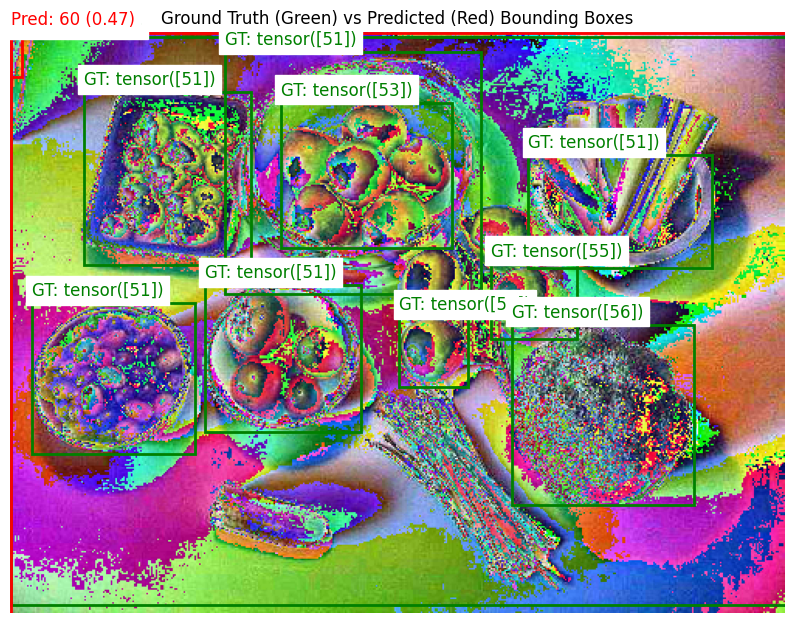

(217, 126, 144, 109)
(353, 190, 22, 32)
(340, 481, 162, 83)
(358, 387, 59, 53)
(219, 0, 179, 69)
(250, 184, 52, 8)
(462, 347, 32, 30)
(227, 229, 81, 27)
(0, 428, 41, 32)
(188, 307, 45, 21)
(103, 277, 49, 61)
(209, 368, 24, 19)
(288, 531, 36, 25)
(302, 75, 28, 20)
(40, 258, 72, 39)
Found: tensor([0])
(145, 476, 13, 17)
(19, 104, 195, 82)
(464, 470, 14, 17)
(86, 577, 26, 35)
(0, 505, 71, 37)
(216, 0, 181, 96)
(24, 113, 50, 71)
(0, 460, 73, 82)
(0, 294, 32, 93)
(385, 145, 14, 26)
(69, 21, 7, 46)
(171, 472, 224, 168)
(177, 529, 34, 63)
(37, 460, 21, 42)
(407, 87, 33, 40)
(83, 574, 27, 35)
(144, 291, 44, 82)
Found: tensor([0])
(7, 230, 110, 19)
(333, 462, 17, 12)
(451, 569, 25, 27)
(217, 383, 18, 14)
(448, 424, 54, 94)
Found: tensor([0])
(439, 146, 16, 18)
(366, 516, 76, 65)
(86, 391, 32, 78)
Found: tensor([0])
(274, 594, 30, 20)
(0, 78, 75, 65)
(87, 275, 148, 115)
Found: tensor([0])
(356, 189, 40, 30)
(220, 98, 33, 28)
(348, 604, 79, 36)
(254, 528, 234, 112)
(117, 592, 25, 33)
(46, 99, 27,

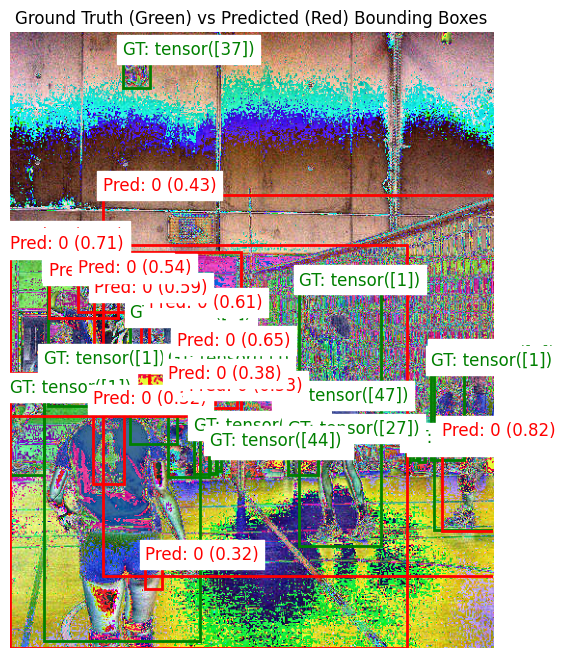

In [23]:
import numpy 

def coco_to_xyxy(box):
    x_min, y_min, width, height = box
    x_max = x_min + width
    y_max = y_min + height
    return [float(x_min), float(y_min), float(x_max), float(y_max)]

# Function to generate bounding boxes and classify them
def generate_and_classify_bounding_boxes(img_tensor, model, confidence_threshold=0.3, iou_threshold=0.7):
    model.eval()
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    image = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image = (image * 255).astype(np.uint8)
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchQuality()
    
    # Generate 200 bounding box proposals
    rects = ss.process()[:200]
    bounding_boxes = []

    for (x, y, w, h) in rects:
        # Ensure bounding box coordinates are valid
        if w <= 0 or h <= 0 or x < 0 or y < 0 or x + w > img_tensor.shape[3] or y + h > img_tensor.shape[2]:
            continue
        print((x,y,w,h))
        # Crop and resize the region of interest (ROI)
        roi = img_tensor[:, :, y:y + h, x:x + w]
        roi_resized = torch.nn.functional.interpolate(roi, size=(224, 224), mode='bilinear', align_corners=False).to(device)

        # Forward pass through the model
        outputs = model(roi_resized)
        probs = torch.softmax(outputs, dim=1)
        confidence, pred_label = torch.max(probs, 1)

        # Only consider proposals with confidence > 30%
        if confidence.item() > confidence_threshold:
            pred_box = coco_to_xyxy([x, y, w, h])
            print(f"Found: {pred_label}")
            # Check if the new box overlaps with existing ones and has the same classification
            should_add = True
            for box in bounding_boxes:
                existing_box = torch.tensor(box['bbox'], dtype=torch.float32).unsqueeze(0)
                new_box = torch.tensor(pred_box, dtype=torch.float32).unsqueeze(0)

                iou = box_iou(existing_box, new_box).item()

                if iou > iou_threshold and box['class'] == pred_label.item():
                    should_add = False
                    break  # Skip adding this box if similar one exists

            if should_add:
                bounding_boxes.append({
                    "bbox": pred_box,
                    "class": pred_label.item(),
                    "confidence": confidence.item()
                })

    return bounding_boxes


# Function to visualize predictions and ground truth bounding boxes
def visualize_predictions(img_tensor, model, target, confidence_threshold=0.3, iou_threshold=0.7):
    # Load the original image
    image = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    image = (image * 255).astype(np.uint8) 
    # Get ground truth bounding boxes and labels
    gt_boxes = [coco_to_xyxy(bbox) for bbox in target["bboxes"]]
    gt_labels = [label for label in target["labels"]]

    # Generate predicted bounding boxes using the model
    predicted_boxes = generate_and_classify_bounding_boxes(img_tensor, model, confidence_threshold, iou_threshold)

    # Plot the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)

    # Plot ground truth boxes in green
    for box, label in zip(gt_boxes, gt_labels):
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          linewidth=2, edgecolor='green', facecolor='none'))
        plt.text(x_min, y_min - 5, f"GT: {label}", color='green', fontsize=12, backgroundcolor='white')

    # Plot predicted bounding boxes in red
    for pred in predicted_boxes:
        x_min, y_min, x_max, y_max = pred["bbox"]
        pred_class = pred["class"]
        confidence = pred["confidence"]
        
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          linewidth=2, edgecolor='red', facecolor='none'))
        plt.text(x_min, y_min - 5, f"Pred: {pred_class} ({confidence:.2f})", 
                 color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.title("Ground Truth (Green) vs Predicted (Red) Bounding Boxes")
    plt.show()

# Example usage
i=0
for img, target in train_loader_raw:
    img = img.to(device)
    # Call the visualization function
    visualize_predictions(img, model, target)
    i+=1
    if i>3:
        break  # Process only the first image for demonstration

I'm not sure what the problem with the color is on the display. I will have to figure this out for next time! In the meantime, observing the images, we see that the overlap between predicted and ground truth is not so good. To redo this whole project, I would move away from the selective segmentation algorithm since during the middle of the project, I noticed that it was a very slow algorithm which did not produce many good candidates for where the object is. In the future, I will use YOLO (you only look once) to cut my image into a grid and run each grid through a CNN so that it can produce a single bounding box and a classification per grid and then combine any overlapping regions.